In [11]:
import xml.etree.cElementTree as ET
import pprint as pp
import re
import codecs
import json
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

k = 100
OSM_FILE = "auckland_new-zealand.osm"  # Replace this with your own osm file for limited reusability!!
SAMPLE_FILE = "auckland_new-zealand_every {}th.osm".format(k)
file_in_use = OSM_FILE

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 'Broadway', 'Motorway', 'Parade',
            "Trail", 'Rise', "Parkway", "Commons", "Crescent", 'Crescent', 'Expressway', 'Terrace', 'Way', 'Close', 'Esplanade', 'Highway', 'Parade']

#expected ones tobe aware of: Cove, Broadway
#used this https://www.landservices.sa.gov.au/1online_services/10propertyassist/Help_for_Business_Users/StreetTypes.asp
mapping = { "St": "Street",
            "St.": "Street",
           'Dr':'Drive',
           'st' : 'Street',
            "street": "Street",
           'strret':'Street',
           'Strret':'Street',
           'road':'Road',
           "Ave":"Avenue",
           "Cr":"Crescent",
            'Rd':'Road',
           'Plc':'Place',
           'ln' : 'Lane',
           'Hwy' : 'Highway'
            }

outliers = {'East':'Street',
            'West':'Street',
            'South':'Road',
            'Strand': None, 
            'Cove': None,
             'Wharf':None,
           "School": None,
            'Tai': None,
            'Coronation' : None,
            'Subritzky' : None,
            'Redwood': None,
            'Hurstmere' : None,
            'Gardens' : None
            
           }

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

In [6]:

def update_name(name, element, node):
    #this has been formatted to work with the final fucntion.
    m = street_type_re.search(name)
    if m:
        street_type = m.group()
        if street_type in expected:
            return name, street_type
        
        elif street_type in mapping:
            new_street_type = mapping[street_type]
            name = name.replace(street_type, new_street_type)
            record_user(element, node)
            return name, new_street_type
        
        elif street_type in outliers:
            record_user(element, node)
            return name, outliers[street_type]
            #IF THE STREET TYPE MAPS TO nONE THEN WE WONT HAVE A STREET TYPE CATEGORY IN THE DATA FOR THIS STREET. good.
        else:

            name, street_type = handle_street_exceptions(name, street_type, element, node)
            record_user(element, node)
            return name, street_type

    else:
        names = name.split(' ')
        if names[-1] in expected:
            return name, names[-1]
        else:
            if name == 'Sartors Avenue ':
                #for some reason this one doesn't register in the screening process
                return 'Sartors Avenue', 'Avenue'
                
            print '\n there is no street type for this one', name
            return name, None

    
def handle_street_exceptions(name, street_type, element, node):
    #check if its a state highway
    if street_type.isdigit():
        if len(name.split(' ')) > 1:
            if name.split(' ')[1] == 'Highway':
                return name, 'Highway'
            else:
                if name == '15 Arrenway Dr, Rosedale, Auckland 0632':
                    return None, None
                print '\n we have a problem with ', name
                return name, street_type
        else:
            if street_type == '26':
                return None, None
            #theres already street data for this one, including the street number
            else:
                print '\n This street name is just a number', name
                return name, street_type

    elif name == 'New Zealand':
        return None, None
    elif name == 'Sartors Avenue':
        return 'Sartors Avenue', 'Avenue'
    elif name == 'Waipuna Road, Mt Wellington':
        names = name.split(' ')
        names[2] = ''
        names[3] = ''
        names[1] = names[1].strip(',')
        name = ''
        name = name.join(names)
        name, street_type = update_name(name, element, node)
    elif name == 'Exmouth Road, Northcote, Auckland':
        return None, None
    elif name == 'Cnr St Lukes Rd & Wagener Plc,':
        name = name.replace('Cnr St Lukes Rd & ', '')
        name = name.strip(',')
        name, street_type = update_name(name, element, node)
        return name, street_type
    elif name == 'Gillies Avenue, Newmarket':
        name = name.replace(', Newmarket', '')
        name, street_type = update_name(name, element, node)
        return name, street_type
    elif street_type == 'Howick)':
        name = name.replace(' (Howick)', '')
        name, street_type = update_name(name, element, node)
        return name, street_type
    elif street_type == 'beach':
        if name == 'Little Oneroa beach':
            name == 'Little Oneroa Beach'
            return name, None
        else:
            
            street_type = None
            names = name.split(' ')
            names[-1] = names[-1].capitalize()
            name = ""
            for n in names:
                name + n + ' '
            print name, street_type, 'xx'
            return name, street_type
    elif name == 'Victoria St W':
        names = name.split(' ')
        names[1] = mapping[names[1]]
        names[2] = 'West'
        name = names[0] + ' ' + names[1] + ' ' + names[2]
        return name, outliers[names[2]]
    elif name == 'WaipunaRoad':
        return 'Waipuna Road', 'Road'
        
            
        
    else:
        print "\n we've found an unexpected one", name, 'and', street_type
        return name, street_type
    
    
def handle_attribute_exceptions(k, v):
    print 'hi;'
    
def record_user(element, node):
    #used to recxord users who dont follow the expected styles of dta entry. This is very rudimentary so if you're one of these 'users' dont be offended.
    if 'bad_user' in node:
        pass
    else:
        if 'user' in node['created'] and 'uid' in node['created']:
            node['bad_user'] = [node['created']['user'], node['created']['uid']]
        elif 'user' in node['created']:
            node['bad_user'] = node['created']['user']
        elif 'uid' in node['created']:
            node['bad_user'] =  node['created']['uid']

In [9]:
def shape_element(element):
    #this will be the function which does themost work
    #we'll only include the node and way tags. 
    
    node = {}
    if element.tag == "node" or element.tag == "way":
        #go through all the initial attribs 
        created = {}
        for c in CREATED:
            try:
                created[c] = element.attrib[c]
            except KeyError:
                pass
            
        node['created'] = created
        try:        
            pos = [float(element.attrib['lat']), float(element.attrib['lon'])]
            node['pos'] = pos
        except KeyError:
            pass
        try:
            node['visible'] = element.attrib['visible']
        except KeyError:
            pass
        node['type'] = element.tag
        node['id'] = element.attrib['id']
        
        
        
        
        address = {}      
        node_refs = []
        testo = True
        param = False
        if testo: 
            for child in element:
                if child.tag == 'nd':
                    node_refs.append(child.attrib['ref'])

                if 'k' in child.attrib:
                    k = child.attrib['k']
                    v = child.attrib['v']
                    if problemchars.search(k):
                        record_user(element, node)
                        #dont think this will happen at all but just in case
                        pass
                    
                    elif k.startswith('addr:'):
                        if len(k.split(':')) == 3:
                            print '\n look at this!', k
                            #this is long
                            
                        else:
                            #find the sub address bit
                            k = k.split(':')[1]
                            if k == 'city':
                                k = 'area'
                                address[k] = v
                                #not clear enough what these values for 'city' represented so changed the category name
                            if k == 'street':
                                street_type = None
                                
                                try:              
                                    v, street_type = update_name(v, element, node)
                                except TypeError:
                                    if v == 'Waipuna Road, Mt Wellington':
                                        v = 'Waipuna Road'
                                        street_type = 'Road'
                                        address['area'] = 'Mt Wellington'
                                        
                                    else:    
                                    #have a look at this Waipuna Road, Mt Wellington street
                                        print 'have a look at this', v, k
                                if v:
                                    address['street'] = v
                                if street_type:
                                    address['street_type'] = street_type
                                if v == '15 Arrenway Dr, Rosedale, Auckland 0632':
                                    v, street_type = update_name('Arrenway Dr')
                                    address['street'] = v
                                    address['housenumber'] = '15'
                                    address['street_type'] = street_type
                                    address['area'] = 'Rosedale'
                                    address['postcode'] = '0632'
                                if v == 'Exmouth Road, Northcote, Auckland':
                                    v, street_type = update_name('Exmouth Road')
                                    address['street'] = v
                                    address['street_type'] = street_type
                                    address['area'] = 'Northcote'
                                    
                                    
                    else:

                        
                        #k will be the val fpor a restaurant or something
                        x = k.split(':')
                        if len(x) == 2:
                            category = x[0]
                            sub_cat = x[1]
                            #problem here is when we have single values which arent dicts. 
                            
                            if category == 'LINZ':
                                pass
                            elif category in node:
                                if type(node[category]) == dict:
                                    node[category][sub_cat] = v
                            
                                else:
                                    #category in node:
                                    category_id = node[category]
                                    node[category] = {}
                                    node[category]['ID'] = category_id
                                    node[category][sub_cat] = v
                            else:                                  
                                node[category] = {}
                                node[category][sub_cat] = v
                        elif len(x) == 1:
                            #assuming the rest will be
                            if k in node:
                                if k == 'type':
                                    pass
                                else:
                                    if type(node[k]) == dict:
                                        print 'this doesnt happen very often1', k, node[k]
                                        print element.tag, element.attrib.items()
                                        for c in element:
                                            print c.attrib.items(), c.tag
                                        #id say we'd have to put numbered keys down
                                    else:
                                        
                                        #id say we'd have to put numbered keys down
                                        if node[k] == '309844804':
                                            node = None
                                            return node
                                            
                                            #this was a surveying entry with entries like [('k', 'calc_area'), ('v', '47251')], and 
                                            #it had an extra ID value wchich was causing errors. 
                                            #so i decided the most efficient thing would be just to remove the node alltogether
                                         
                                        print 'this doesnt happen very often2', k, node[k]
                                        print element.tag, element.attrib.items()
                                        for c in element:
                                            print c.attrib.items(), c.tag
                            else:
                                node[k] = v
                                
                                
        if len(node_refs) != 0:
            node['node_refs'] = node_refs
        if len(address) != 0:
            node['address'] = address
            
        return node
    else:
        return None

                    
                        
                        

def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                #data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2) + "\n")
                else:
                    fo.write(json.dumps(el) + "\n")
        
    return data

def test():
    # NOTE: if you are running this code on your computer, with a larger dataset, 
    # call the process_map procedure with pretty=False. The pretty=True option adds 
    # additional spaces to the output, making it significantly larger.
    data = process_map(file_in_use)
    #pprint.pprint(data)
    return data

data = test()
print 'done'

done





Problems I came across in the processing step:
-Inconsistent address recording and recording style.
-Inconsistent area category naming. (some areas are recorded to a good degree of accuracy, others refer to a large area in auckland such as 'Auckland' which is more of a general area in Auckland which includes a lot of the most central areas of the city.)



The file processing method involved processing the address's for each Node/Way tag. Doing this, I found a fair few inconsistencies. A lot could be cleaned up using similar code to that used in 'Improving Street Names' from the Case Study quiz, but there was a proportion which I had to clean up almost manually. They would have multiple problems, one of them that came up often was some street address's were recorded in the same line as their postcode, city area and other address categories. I had to sort these and put them into their proper categories for the JSON document. For example 'Exmouth Road, Auckland' has the 'Area' category included in it (Auckland)(This is something probably only noticed by a New Zealander - Auckland being the central area of Auckland). Problems like this have had to be raised during processing and exceptions/solutions written in the 'handle_street_exceptions' function to fix them. 
While going through exceptions to my original code and updating my functions to handle those exceptions I used the list of street types in this website to differentiate between a valid street type or an instance where I'd leave out the street type detail. (https://www.landservices.sa.gov.au/1online_services/10propertyassist/Help_for_Business_Users/StreetTypes.asp).

As for the inconsistent area naming, I don't yet know how to write a process to automatically map street addresses to city areas using external data. Perhaps I'll learn this later in the course?! 
- I feel the area naming is still good enough to make observations during the query process.

I wonder if specific users are responsible for the bad address naming conventions and if so a faster method of processig the data is through quickly identifying and then looking for those users and then their bad data. This would save having to trawl through all of the data points individually usign my long iterative screening process for bad data.
- Note on this, I've included data points for all those street addresses where I've had to make changes to them.

My processing didn't involve much more than what I've explained. I was processing the files with the intention of looking at the address data so I didn't worry about any other potenital inconsistencies in the data. 

To note, compared to many other examples of this project, my processing stage looks a lot more messy. I believe this is because of how detailed my investigation and data cleaning efforts were. I wanted my data to be as complete as possible to gather as accurate statistics as I could. Furthermore with regards to how messy it is, it's worth noting here that I've detailed what parts of the shape element function are specific to the Auckland data set, so you can use the base of my code on other OSM data.
If anyone has any advice as tohow to better handle this 'messy' code scenario please let me know as I want to be the best programmer that I can be. 






For example, the Street name which is found in a tag, tag, comes under the 'k' attribute 'address:street' and the 'v' attribute 'Cracroft Strret' is processed so in the JSON document there will be now a node/way with an address category like so:
'address': {'street':'Carcroft Street', 'street_type':'Street'}    - There could also be extra details in the address like Postcode and Housenumber.



The analysis phase:

Starting out with MongoDb i struggled with how to actually import my .json document. For future reference the following import statement is to be used in cmd, without mongo.exe running.

>cd C:\Users\O'l Mate>cd C:\Program Files\MongoDB\Server\3.4\bin
>mongoimport --db Udacity --collection osm --file auckland_new-zealand.osm.json

(database = Udacity, collection = osm)
Once the file is imported we can start using mongo.exe or even pymongo to make queries. 

To improve readability of the project I've chosen to use pymongo. The connection process is specified below: 


In [6]:
#connection process (note, mongod.exe must be running to connect)
from pymongo import MongoClient
client = MongoClient()
db = client.Udacity
#assign 'coll' variable to the osm collection for future use.
coll = db.osm

#function to be used throughout analysis
def print_query_results(query, title):
    print title
    for x in query:
        pp.pprint(x)

In [67]:
print 'Find the most common street types:'
common_street_types = coll.aggregate([{"$group":{"_id":"$address.street_type", "count" : {"$sum" : 1}}}, {"$sort" : {"count" : -1}}, {"$limit":5}])
query_results(common_street_types, 'common_street_types')

print 'Find most common area:'
common_areas = coll.aggregate([{"$group":{"_id":"$address.area", "count" : {"$sum" : 1}}}, {"$sort" : {"count" : -1}}, {"$limit":5}])
query_results(common_areas, 'common_areas')

print 'Find amenities'
common_amenities = coll.aggregate([{"$match":{"amenity":{"$exists":1}}}, {"$group":{"_id":"$amenity", "count":{"$sum":1}}}, {"$sort":{"count":-1}}, {"$limit":10}])
query_results(common_amenities, 'common_amenities')

I'm interested as to what the top users were (those who made the most nodes in the osm file) and if there were any obvious patterns as to what city areas they covered individually. For example did the top user cover a wide range of areas or just one? 
Furthermore I want to compare these findings to the bad_users. These users weren't specifically bad, they just inputted the data in different styles/formats so I had to format it during the processing stage. The hope is that these users covered specific areas, amenities or types, making it easier to find them during the processing stage.



In [84]:
def find_user_areas(category, user):
    
    results = coll.aggregate([{"$match":{category:user}}, 
                   {"$group":{"_id" : "$address.area", "count":{"$sum":1}}}, 
                   {"$sort":{"count":-1}},{"$limit":3}])
    return print_query_results(results, 'user_areas for {}'.format(user))

print "Firstly we look at the top users and the areas they covered: \n"

top_users = coll.aggregate([{"$group":{"_id":"$created.user", "count":{"$sum":1}}}, {"$sort":{"count":-1}}, {"$limit":10}])

for users in top_users:
    user, count = users['_id'], users['count']
    print user, count
    print find_user_areas("created.user", user)
#query_results(top_users, 'top_users')

print "\n Now for the bad users: \n"

bad_users = coll.aggregate([{"$group":{"_id":"$bad_user", "count":{"$sum":1}}}, {"$sort" : {"count":-1}},{"$limit":10}])

for users in bad_users:
    user, count = users['_id'], users['count']
    print user, count
    find_user_areas("bad_user", user)

StephenDavis 1349144
user_areas for StephenDavis
{u'_id': None, u'count': 1349142}
{u'_id': u'Snells Beach', u'count': 1}
{u'_id': u'Glen Eden', u'count': 1}
None
Rudy355 528735
user_areas for Rudy355
{u'_id': None, u'count': 528657}
{u'_id': u'Auckland', u'count': 46}
{u'_id': u'North Shore City', u'count': 5}
None
mrsid_linz 331401
user_areas for mrsid_linz
{u'_id': None, u'count': 331401}
None
myfanwy 254544
user_areas for myfanwy
{u'_id': None, u'count': 254388}
{u'_id': u'Auckland', u'count': 133}
{u'_id': u'Epsom', u'count': 5}
None
Robert Ancell 190660
user_areas for Robert Ancell
{u'_id': None, u'count': 190651}
{u'_id': u'Auckland', u'count': 9}
None
barnaclebarnes_linz 156731
user_areas for barnaclebarnes_linz
{u'_id': None, u'count': 156719}
{u'_id': u'Auckland', u'count': 12}
None
LINZ Data Upload 97181
user_areas for LINZ Data Upload
{u'_id': None, u'count': 97176}
{u'_id': u'Auckland', u'count': 5}
None
more-ron 35769
user_areas for more-ron
{u'_id': None, u'count': 35767

Unfortuanetly in these findings too few users inputted the city area very precisely and instead either recorded Auckland (which is too general an area) or None. As a result I haven't uncovered any major areas for the bad users. However, for one of the top users, lcmortensen, the user recorded 49 'North Shore City' data points. I feel there could definitely be a pattern here so we'll have a look at how many data points there are for the 'North Shore City' area:


In [85]:
north_shore_count = coll.aggregate([{"$match" : {"address.area":"North Shore City"}},
                                    {"$group":{"_id":"$address.area", "count":{"$sum":1}}}])

print_query_results(north_shore_count, 'number of north shore data points recorded')


number of north shore data points recorded
{u'_id': u'North Shore City', u'count': 69}


From this we can see that in fact the user, lcmortenson, recorded 49 of 69 data points for North Shore City, which is a lot. Although the user recorded 28963 data points all up, from the findings we could still suggest that some users may record data points by area.
I still want to see if there were any patterns as to what categories users cover. This time I'll try amenities but also try improve the likelihood of finding patterns by finding users by finding the ones who's data entries were taken up by a large proportion of a single amenity. Ie. 20% of Bills records covered Restaurants leading us to think there could be a correlation between what field values and what data points the users record.



In [17]:
y = coll.aggregate([
    {"$match":{"amenity":{"$exists":True}}},
    {"$group":{"_id":{"user":"$created.user", "amenity":"$amenity"}, "count":{"$sum":1}}},
    {"$group":{"_id":"$_id.user", "total":{"$sum":"$count"}, "amenities":{"$push":{"amenity" :"$_id.amenity","count":"$count"}}}},
    {"$unwind":"$amenities"},
    {"$project" : {"_id" :0 ,"user":"$_id", "amenity":"$amenities.amenity", "record":{"$divide":["$amenities.count", "$total"]}}},
    {"$sort":{"record":1}}
])     
    
print_query_results(y, 'Finding how many of each amenity each user records:')

Finding how many of each amenity each user records:
{u'amenity': u'proposed',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'prison', u'record': 0.00015820281601012498, u'user': u'Rudy355'}
{u'amenity': u'retirement_village',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'fountain',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'nursing_home',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'bicycle_parking',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'bench', u'record': 0.00015820281601012498, u'user': u'Rudy355'}
{u'amenity': u'marae', u'record': 0.00015820281601012498, u'user': u'Rudy355'}
{u'amenity': u'waste_basket',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'parking_entrance',
 u'record': 0.00015820281601012498,
 u'user': u'Rudy355'}
{u'amenity': u'charging_station',
 u'record': 0.00031640563202024995,
 u'user': u'Rudy355

Following these findings I realised that the distribution of users and how many recordings they each do may have more of an effetc than i anticipated on my findings. So I've created a distribution of user recording levels:

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
#connection process (note, mongod.exe must be running to connect)
from pymongo import MongoClient
client = MongoClient()
db = client.Udacity
#assign 'coll' variable to the osm collection for future use.
coll = db.osm

#function to be used throughout analysis
def array_from_query_results(query):
    array = []
    for x in query:
        array.append(x['user_count'])
    return array
        


#user recordings:
users = coll.aggregate([{"$group":{"_id":"$created.user", "user_count":{"$sum":1}}},
                        {"$sort":{"user_count":-1}}])    
uid = coll.aggregate([{"$group":{"_id":"$created.uid", "user_count":{"$sum":1}}},
                      {"$sort":{"count":-1}}])   


user_array = array_from_query_results(users)
uid_array = array_from_query_results(uid)




user_array = np.array(user_array)
uid_array = np.array(uid_array)


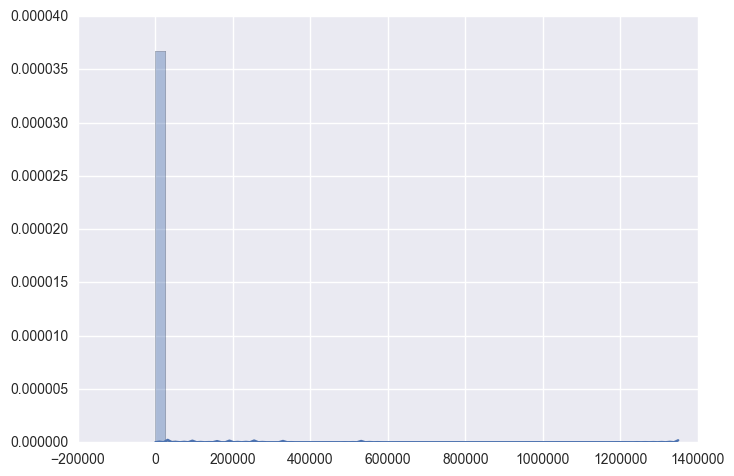

In [21]:
g = sns.distplot(user_array);

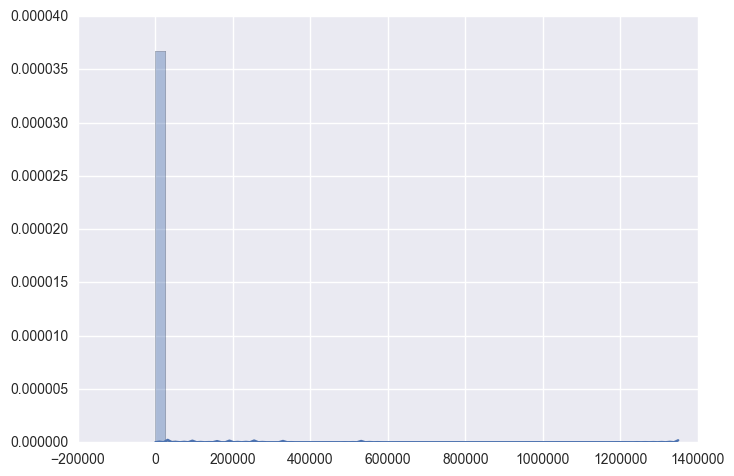

In [22]:
x = sns.distplot(uid_array);

As we can see from this distribution, there are a lot of users who inputted only small amounts of data.(and no major difference between the stats for 'uid' and 'user', phew.) This leads me to think that perhaps the more extreme amounts of data are recorded by a computer. With regards to the recoding bias study, I'm going to leave that until I learn better statistical skills and tools but I'm going to move onto seeing if computers were doing the heavy amounts of data. I can do this by looking at the bad user stats. My hypothesis is that the bad users (human recorders - machines don't make mistakes like those i was fixing) were those who recorded less data points, in that heavily populated area on the far right of the distribution!
To do this I'll find all the bad users and then create the same distribution but this time only inputting the bad users to the chart. 


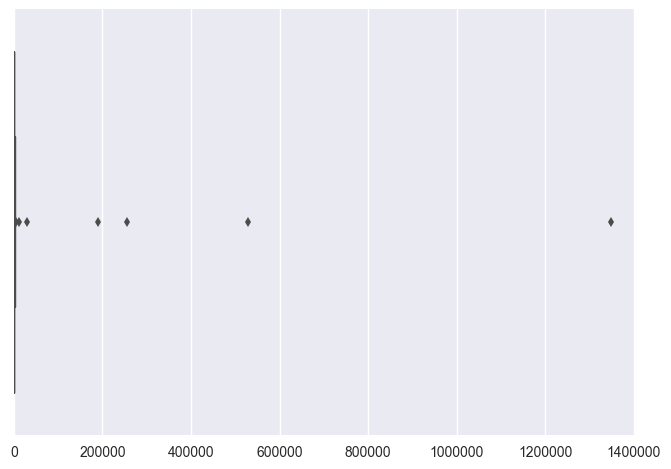

In [51]:
bad_users = coll.aggregate([{"$group":{"_id":"$bad_user"}}])
users = coll.aggregate([{"$group":{"_id":"$created.user", "user_count":{"$sum":1}}}])    

temp_list = []
bad_list=[]
for bads in bad_users:
    u = bads['_id']
    temp_list.append(u)
    

for x in temp_list[:-1]:
    bad_list.append(x[0])
    

bad_users_array = []

for user in users:
    if user['_id'] in bad_list:
        bad_users_array.append(user['user_count'])

bad_users_array = np.array(bad_users_array)
   
y = sns.distplot(bad_users_array)

It's actually really similar. From this we don't have any clear evidence to suggest the distribution of the bad users is different to the normal users. 

In the future I'd like to find better ways of displaying the data so I can make better inferences. Until then, here's to the next Udacity course in R!